In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import sys
sys.path.append('../../')
from pydicts.obsdict import get_FINO_obs
from mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv,w_s,T_d
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
from mmctools.helper_functions import calc_wind
from mmctools.plotting import TaylorDiagram
import wrf
from netCDF4 import Dataset
import matplotlib.colors as colors
import scipy.stats as stats
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import matplotlib.patches as patches
from string import ascii_lowercase

# Where to save the images:

In [3]:
save_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/'

# Read in buoy data:

In [4]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_type = 'combined' # combined or CBIBS or NDBC
#obs_dir = '{}{}/'.format(obs_f_dir,obs_type)
buoy_f = '{}{}_buoy_data_res_2019.nc'.format(obs_f_dir,obs_type)
obs_ds = xr.open_dataset(buoy_f)

In [5]:
buoy_loc_dict = {}
for stn in obs_ds.station.data:
    buoy_loc_dict[stn] = {'lat':float(obs_ds.sel(station=stn).lat.data),
                     'lon':float(obs_ds.sel(station=stn).lon.data)}



### Buoys PMC, GRF and SRP have bad or no data for this period, CAM, SLM, and WDC are on land

In [6]:
buoy_list = list(buoy_loc_dict.keys())

buoy_loc_dict['JTN']['lat'] = 37.21137
buoy_loc_dict['JTN']['lon'] = -76.78677

bad_buoys = ['PMC','GRF','SRP','CAM','SLM','WDC']

for bad_buoy in bad_buoys:
    buoy_list.remove(bad_buoy)

# Extract WRF data at buoy locations

In [7]:
wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'
work_dir   = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


# Load the case dictionary file specifying case names, domains, colors, and markers

In [8]:
from CBB_case_dict import case_dict
cases = list(case_dict.keys())

ncases   = len(cases)
case_dom = [3]*ncases

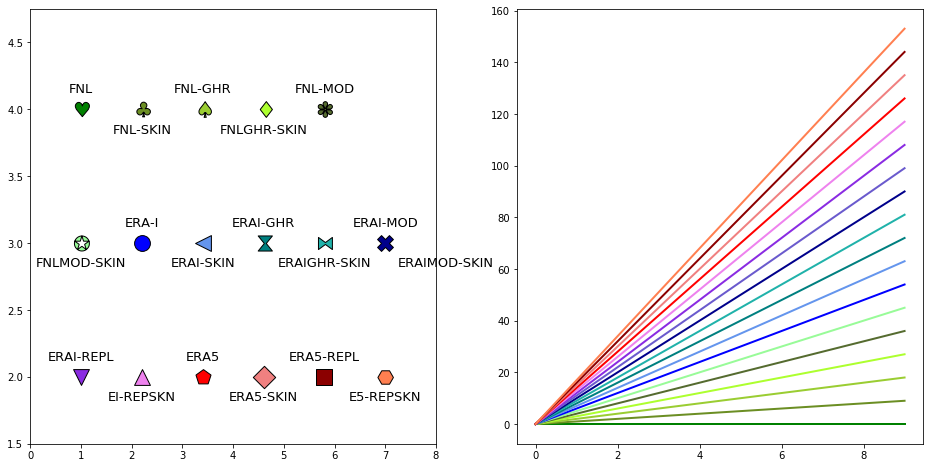

In [9]:
x_p = 1
y_p = 4
x = np.arange(0,10)
count = 0
top = True
fig,ax = plt.subplots(figsize=(16,8),ncols=2)
for cc,case in enumerate(case_dict):
    case_d = case_dict[case]
    for dom_d in case_d:
        plt_d = case_d[dom_d]
        
        if top:
            vadj = 0.1
        else:
            vadj = -0.2
        
        if plt_d['fill']:
            marker_c = plt_d['color']
            marker_e = 'k'
        else:
            marker_c = plt_d['color']
            marker_c = 'k'
            marker_e = plt_d['color']

        
        #if not plt_d['fill']:
        #    ax[0].scatter(x_p,y_p,c='k',marker=plt_d['marker'],edgecolors='k',lw=3.0,s=150)
        ax[0].scatter(x_p,y_p,c=marker_c,marker=plt_d['marker'],edgecolors=marker_e,s=250,zorder=3)
        ax[0].text(x_p,y_p+vadj,plt_d['name'],ha='center',va='bottom',size=13)
        x_p += 1.2
        if (plt_d['name'] == 'ERAIMOD-SKIN') or (plt_d['name'] == 'ERA-GHR') or (plt_d['name'] == 'FNL-MOD'):
            x_p = 1
            y_p -= 1
            
        
        ax[1].plot(x,x*count,c=plt_d['color'],lw=2.0)
        if top:
            top = False
        else:
            top = True
        count += 1
ax[0].set_ylim(1.5,4.75)    
ax[0].set_xlim(0.0,8.0)
plt.show()

### Read in WRF output at location of buoys

In [11]:
wrf_buoys = {}
for cc,case in enumerate(cases):
    new_f_name = '{0}{1}/{1}_extracted_{2}_buoy_data_d0{3}.nc'.format(work_dir,case,obs_type,case_dom[cc])
    if path.exists('{}'.format(new_f_name)):
        print('Data for {} already created!'.format(new_f_name.split('/')[-1]))
        wrf_buoys['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = xr.open_dataset('{}'.format(new_f_name))
    else:
        print(case, new_f_name)
        get_wrf_locs = True
        rst_dict = {}
        for rr,rst in enumerate(restarts):
            print('starting {}'.format(rst))
            f_list = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,case,rst,case_dom[cc])))

            if get_wrf_locs:
                wrf_loc_dict = {}
                wrf_i = Dataset('{}/wrfinput_d0{}'.format('/'.join(f_list[0].split('/')[:-1]),case_dom[cc]))
                is_water = [True]*len(buoy_loc_dict)
                hgt      = np.zeros(len(buoy_loc_dict))
                for ss,stn in enumerate(buoy_loc_dict):
                    wrf_loc_dict[stn] = {}
                    loc_x,loc_y = wrf.ll_to_xy(wrf_i,buoy_loc_dict[stn]['lat'],buoy_loc_dict[stn]['lon'])
                    loc_x = int(loc_x.data)
                    loc_y = int(loc_y.data)
                    # Some buoy locations are on land... grab the water cell next to it
                    if obs_type == 'CBIBS':
                        if stn == 'ANN':loc_x += 1
                    elif (obs_type == 'NDBC') or (obs_type == 'combined'):
                        if stn == 'CAM':loc_y += 1
                        if stn == 'SLM':loc_x += 1


                    #print(loc_x,loc_y)
                    wrf_loc_dict[stn]['x'] = loc_x
                    wrf_loc_dict[stn]['y'] = loc_y
                    #print(wrf_loc_dict[stn])
                    # Check WRF is grabbing right locations:
                    wrf_lat = wrf_i.variables['XLAT'][0,loc_y,loc_x]
                    wrf_lon = wrf_i.variables['XLONG'][0,loc_y,loc_x]
                    landmask = wrf_i.variables['LANDMASK'][0,loc_y,loc_x]
                    hgt[ss]  = wrf_i.variables['HGT'][0,loc_y,loc_x]
                    if landmask == 1:
                        is_water[ss] = False
                get_wrf_locs = False
                wrf_i.close()
            wrf_times = []

            wspd = np.zeros((len(f_list),len(buoy_loc_dict)))
            wdir = np.zeros((len(f_list),len(buoy_loc_dict)))
            t2   = np.zeros((len(f_list),len(buoy_loc_dict)))
            tsk  = np.zeros((len(f_list),len(buoy_loc_dict)))
            pres = np.zeros((len(f_list),len(buoy_loc_dict)))
            dwpt = np.zeros((len(f_list),len(buoy_loc_dict)))
            sst  = np.zeros((len(f_list),len(buoy_loc_dict)))
            

            for ff,fname in enumerate(f_list):
                wrf_f = Dataset(fname)
                wrf_times.append(wrf.extract_times(wrf_f,timeidx=0))
                for ss,stn in enumerate(buoy_loc_dict):
                    u10 = wrf_f.variables['U10'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    v10 = wrf_f.variables['V10'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]

                    wspd[ff,ss] = (u10**2 + v10**2)**0.5
                    wdir[ff,ss] = 180. + np.degrees(np.arctan2(u10, v10))
                    t2[ff,ss]   = wrf_f.variables['T2'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    tsk[ff,ss]  = wrf_f.variables['TSK'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    pres[ff,ss] = wrf_f.variables['PSFC'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]/100.0
                    mixingratio = wrf_f.variables['Q2'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    w_sat       = w_s(t2[ff,ss],pres[ff,ss])
                    rh          = (mixingratio/w_sat)*100.0
                    dwpt[ff,ss] = T_d(t2[ff,ss],rh,celsius=True)
                    
                    try:
                        sst[ff,ss]  = wrf_f.variables['SST'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    except KeyError:
                        if ff == 0 and ss == 0: print('no SST data found... setting to zero')
                        sst[ff,ss] = tsk[ff,ss]*0.0
                    

                wrf_f.close()
            rst_dict[rst] = xr.Dataset({'wspd': (['datetime','station'],wspd),
                                        'wdir': (['datetime','station'],wdir),
                                        't2'  : (['datetime','station'],t2),
                                        'tsk' : (['datetime','station'],tsk),
                                        'sst' : (['datetime','station'],sst),
                                        'pres': (['datetime','station'],pres),
                                        'dwpt': (['datetime','station'],dwpt),
                                    'is_water': (['station'],is_water),
                                         'hgt': (['station'],hgt)},
                                        coords={'datetime':wrf_times,
                                                'station': list(buoy_loc_dict.keys())})             
            if rr == 0:
                full_ds = rst_dict[rst]
            else:
                full_ds = full_ds.combine_first(rst_dict[rst])

        full_ds.to_netcdf(new_f_name)
        wrf_buoys['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))]  = full_ds


        fig = plt.figure(figsize=(18,6))
        full_ds.sel(station='ANN').dwpt.plot(lw=2.0,c='k')
        for rr,rst in enumerate(rst_dict):
            rst_dict[rst].sel(station='ANN').dwpt.plot(lw=1.0)
        plt.show()
        


Data for GFSR_YSU_CHRN_GFS_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GFS_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GHR_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GHR_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_MOD_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_MOD_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_OST_NOSK_4DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_OST_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_GHR_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_GHR_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_MOD_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for E

In [12]:
t_s = wrf_buoys['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[0] + pd.to_timedelta(12,'h') - pd.to_timedelta(3,'s') # Account for spinup
t_e = wrf_buoys['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[-1]

In [13]:
for case in wrf_buoys:
    for stn in buoy_list:
        is_water = wrf_buoys[case].sel(station=stn).is_water.data
        #if not is_water and stn in buoy_list:
        if not is_water:
            print('{}: {} is on land'.format(case,stn))

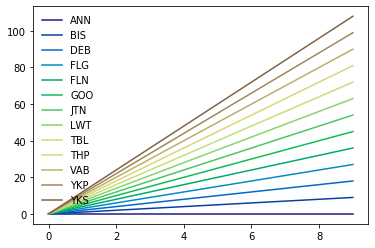

In [14]:
stn_colors = {}
for ss,stn in enumerate(buoy_list):
    line_cols = plt.cm.terrain(np.linspace(0.0,0.7,len(buoy_list)))[ss]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    stn_colors[stn] = line_cols
for ss,stn in enumerate(buoy_list):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[stn],label=stn)
plt.legend(frameon=False)
plt.show()

# Resample obs and WRF to common times:

### FLN has some erroneous data that can be removed:

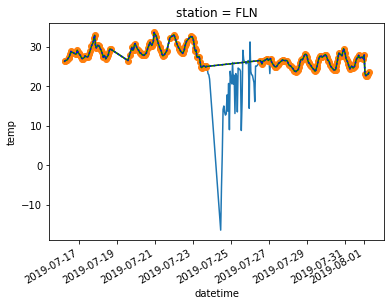

In [15]:
if 'FLN' in obs_ds.station.data:
    temp_obs = obs_ds.temp.copy()
    obs_ds = obs_ds.drop_vars('temp')

    fln = temp_obs.sel(station='FLN')
    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot()

    rem_starts = ['2019-07-23 18:00:00','2019-07-27 00:00:00']
    rem_ends  = ['2019-07-26 12:00:00','2019-07-27 01:45:00']


    for rem_s,rem_e in zip(rem_starts,rem_ends):
        fln.sel(datetime=slice(rem_s,rem_e)).data[:] = fln.sel(datetime=slice(rem_s,rem_e)).data[:]*np.nan

    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(marker='o')

    temp_obs.sel(station='FLN').data = fln.data

    temp_obs.sel(station='FLN').sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(c='g')
    obs_ds['temp'] = temp_obs

    obs_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')
    plt.show()

# Calculate u and v for histograms/scatter plots

In [16]:
obs_ds['u'],obs_ds['v'] = calc_uv(obs_ds)

for cc,case in enumerate(wrf_buoys):
    wrf_buoys[case]['u'],wrf_buoys[case]['v'] = calc_uv(wrf_buoys[case])


# Which variables are going to be compared:

In [17]:
vars_to_compare = { 'sst':'tsk',
                   'temp':'t2',
                   'wspd':'wspd'
                   #'pres':'pres',
                   #'wdir':'wdir',
                   #   'u':'u',
                   #   'v':'v'
                  }

In [18]:
def resample_model_output(stn_ds,obs_ds,var_dict,adjustments=None,select_stations=None):
    for vv,var in enumerate(var_dict):
        obs_var = var
        stn_var = var_dict[var]

        temp_ds = stn_ds.copy()
        temp_ds.drop_vars(stn_var)
        temp_var = stn_ds[stn_var].copy()
        if adjustments is not None and len(adjustments) == len(var_dict):
            adjustment = adjustments[vv]
            if adjustment is not None:
                print('Adjusting {} by {}'.format(var,adjustment))
                if adjustment[0] == '+' or adjustment[0] == '-':
                    temp_var += float(adjustment)
                elif adjustment[0] == '*':
                    temp_var = temp_var*float(adjustment[1:])
                elif adjustment[0] == '/':
                    temp_var = temp_var/float(adjustment[1:])
                else:
                    print('adjustment {} not understood. Please use +, -, *, or /'.format(adjustments))
        if select_stations is not None:
            station_list = select_stations
        else:
            station_list = stn_ds.station.data
        for ss,stn in enumerate(station_list):
            if type(obs_ds) == dict:
                obs = obs_ds[stn]
            elif type(obs_ds) == xr.core.dataset.Dataset:
                obs = obs_ds.sel(station=stn)
            else:
                'Need to figure out data type of obs_ds'
            var = temp_var.sel(station=stn)
            
            var[np.where(np.isnan(obs[obs_var].data))] = var[np.where(np.isnan(obs[obs_var].data))]*np.nan

            temp_var.sel(station=stn).data = var.data

        stn_ds[stn_var] = temp_var
    return(stn_ds)

In [19]:
obs_res = obs_ds.copy().sel(datetime=slice(t_s,t_e))
obs_res = obs_res.resample(datetime='1h').nearest(tolerance='15m')

wrf_buoys_res = {}
for cc,case in enumerate(wrf_buoys):
    print(case)
    wrf_buoys_res[case] = resample_model_output(wrf_buoys[case].copy().sel(datetime=slice(t_s,t_e)),
                                                obs_res,var_dict=vars_to_compare,
                                                adjustments=['-273.15','-273.15',None])#,None,None,None])
    

GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_GHR_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_GHR_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_MOD_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_MOD_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_OST_NOSK_4DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_OST_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_MOD_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI

In [20]:
obs_res['t_diff'] = obs_res.temp - obs_res.sst

for cc,case in enumerate(wrf_buoys):
    wrf_buoys_res[case]['t_diff'] = wrf_buoys_res[case].t2 - wrf_buoys_res[case].tsk


# Taylor Diagrams

In [21]:
remove_mean = False

remove_low_wspds = False
wspd_cutoff = 1.4

remove_night = True
night_hour_s = 22
night_hour_e = 12

only_observed_bb_days = False

save_figs   = True


TD_stns = list(buoy_list.copy())

TD_stns.remove('DEB') # Remove deep water stations
TD_stns.remove('VAB') # Remove deep water stations
#TD_stns.remove('TBL') # TBL doesn't have wind data...


markers = [(i,j,0) for i in np.arange(2,len(cases)*2) for j in range(1, 2)]
markers = ['o','^','P','X','D','p','d','h','v']

bb_observed_dates = {'StaufferThompson2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-09' : ['MTN', 'NAK'],
                                                '2019-07-10' : ['NUI'],
                                                '2019-07-11' : ['NAK'],
                                                '2019-07-15' : ['MTN', 'NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-17' : ['NAK'],
                                                '2019-07-19' : ['MTN'],
                                                '2019-07-20' : ['MTN'],
                                                '2019-07-24' : ['NUI'],
                                                '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                                '2019-07-27' : ['MTN', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['MTN', 'NAK', 'NHK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                             'Stauffer2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-07' : ['NHK'],
                                                '2019-07-09' : ['NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NAK', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['NAK', 'NHK'],
                                                '2019-07-30' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                               'Sikora2010': {  '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NHK'],
                                                '2019-07-28' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']}
                    }


bay_breeze_days_from_obs = []
for meth in bb_observed_dates:
    meth_dates = bb_observed_dates[meth]
    for date in meth_dates:
        bay_breeze_days_from_obs.append(date)
    
bay_breeze_days_from_obs = list(np.unique(bay_breeze_days_from_obs))

#bay_breeze_days_from_obs = ['2019-07-09','2019-07-10','2019-07-11','2019-07-15',
#                            '2019-07-16','2019-07-17','2019-07-19','2019-07-20',
#                            '2019-07-24','2019-07-26','2019-07-27','2019-07-28',
#                            '2019-07-29','2019-07-31']

TD_start = '2019-07-19 00:00:00'
TD_end   = '2019-07-21 00:00:00'

var_str_dict = {'sst':'WST [˚C]',
               'wspd':'Wind Speed [m s$^{-1}$]'}

TD_start = t_s
TD_end   = t_e

In [22]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

cases_of_interest = [
                    'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                    'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                    'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                    ]
doms_of_interest  = [3]*len(cases_of_interest)

In [23]:
buoy_list_full = buoy_list.copy()

In [24]:
TD_obs_full = {}

for ss,stn in enumerate(buoy_list):
    temp_obs_ds = obs_res.sel(station=stn).copy()
    for var in vars_to_compare:
        obs_var = var
        temp_obs_ds.drop_vars(obs_var)
        obs = obs_res.sel(station=stn)[obs_var].copy()
        plt_start_date = pd.to_datetime(obs.datetime.values[0])
        plt_end_date = pd.to_datetime(obs.datetime.values[-1])
        if obs_var == 'wdir':
            obs = np.cos(np.radians(270. - obs))*np.sin(np.radians(270. - obs))
            obs_var = 'wdirA'
            
        if remove_night:
            for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
                night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
                night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
                obs.sel(datetime=slice(night_s,night_e)).data[:] = obs.sel(datetime=slice(night_s,night_e)).data*np.nan   
                
        if only_observed_bb_days:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
                if day_str not in bay_breeze_days_from_obs:
                    day_s = pd.to_datetime(day_str)
                    day_e = day_s + pd.Timedelta(1,'d')
                    obs.sel(datetime=slice(day_s,day_e)).data[:] = obs.sel(datetime=slice(day_s,day_e)).data*np.nan
        temp_obs_ds[obs_var] = obs
        
    TD_obs_full[stn] = temp_obs_ds
    

TD_wrf_buoys = {}
for cc,case in enumerate(cases):

    temp_twr_ds = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))].copy()

    for vv,var in enumerate(vars_to_compare):
        obs_var = var
        sim_var = vars_to_compare[var]

        if var != 'wdir':
            temp_twr_ds = temp_twr_ds.drop_vars(sim_var)
        
        temp_var = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))][sim_var].copy()
        
        for ss,stn in enumerate(buoy_list):
            
            td_var = temp_var.sel(station=stn)

            obs = TD_obs_full[stn][obs_var]
                        
            if var == 'wdir':
                td_var = np.cos(np.radians(270. - td_var))*np.sin(np.radians(270. - td_var))
                sim_var = 'wdirA'
            td_var[np.where(np.isnan(obs))] = np.nan

            if remove_mean: td_var = td_var - td_var(temp_var,2016/32,0)
                           
            temp_var.sel(station=stn).data[:] = td_var.data[:]

        temp_twr_ds[sim_var] = temp_var
    TD_wrf_buoys[case] = temp_twr_ds


# Time Series side x side (SST / wind speed)

In [25]:
TD_obs_full_sub = {}
remove_night_sub = False
for ss,stn in enumerate(buoy_list):
    temp_obs_ds = obs_res.sel(station=stn).copy()
    for var in vars_to_compare:
        obs_var = var
        temp_obs_ds.drop_vars(obs_var)
        obs = obs_res.sel(station=stn)[obs_var].copy()

        if obs_var == 'wdir':
            obs = np.cos(np.radians(270. - obs))*np.sin(np.radians(270. - obs))
            obs_var = 'wdirA'
            
        if remove_night_sub:
            for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
                night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
                night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
                obs.sel(datetime=slice(night_s,night_e)).data[:] = obs.sel(datetime=slice(night_s,night_e)).data*np.nan   
                
        if only_observed_bb_days:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
                if day_str not in bay_breeze_days_from_obs:
                    day_s = pd.to_datetime(day_str)
                    day_e = day_s + pd.Timedelta(1,'d')
                    obs.sel(datetime=slice(day_s,day_e)).data[:] = obs.sel(datetime=slice(day_s,day_e)).data*np.nan
        temp_obs_ds[obs_var] = obs
        
    TD_obs_full_sub[stn] = temp_obs_ds
    

TD_wrf_buoys_sub = {}
for cc,case in enumerate(cases_of_interest):

    temp_twr_ds = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))].copy()

    for vv,var in enumerate(vars_to_compare):
        obs_var = var
        sim_var = vars_to_compare[var]

        if var != 'wdir':
            temp_twr_ds = temp_twr_ds.drop_vars(sim_var)
        
        temp_var = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].copy()
        
        for ss,stn in enumerate(TD_stns):
            
            td_var = temp_var.sel(station=stn)

            obs = TD_obs_full_sub[stn][obs_var]
                        
            if var == 'wdir':
                td_var = np.cos(np.radians(270. - td_var))*np.sin(np.radians(270. - td_var))
                sim_var = 'wdirA'
            td_var[np.where(np.isnan(obs))] = np.nan

            if remove_mean: td_var = td_var - td_var(temp_var,2016/32,0)
                           
            temp_var.sel(station=stn).data[:] = td_var.data[:]

        temp_twr_ds[sim_var] = temp_var
    TD_wrf_buoys_sub[case] = temp_twr_ds



/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/ICBC_SST_timeseries


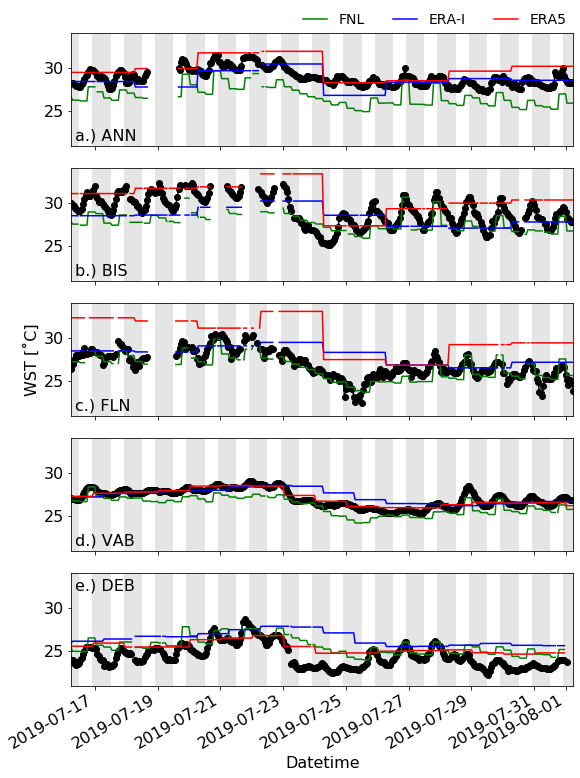

In [37]:
stns_for_plot = ['ANN','BIS','FLN','VAB','DEB']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(len(stns_for_plot),sharex=True,figsize=(9,12))
for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full_sub[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys_sub[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss],c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])

    ax[ss].set_ylabel(sim_var,size=16)
    if ss == len(TD_stns) - 1:
        ax[ss].set_xlabel('Datetime',size=16)
    else:
        ax[ss].set_xlabel('')
    if ss == 0:
        ax[ss].set_title(var,size=18)
    else:
        ax[ss].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 21,34
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    ax[ss].set_yticks(np.arange(5,46,5))
    ax[ss].set_ylim(ymin,ymax)
    ax[ss].tick_params(labelsize=16)
    if ss == 2:
        ax[ss].set_ylabel(var_str_dict[var],size=16)
    else:
        ax[ss].set_ylabel('')

    ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
#    ax[ss].text(obs.datetime.data[5],ymax + 0.01*(ymax-ymin),stn,va='bottom',ha='left',size=16)
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax[ss].text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
ax[0].legend(frameon=False,ncol=4,loc=(0.45,1.01),fontsize=14,handlelength=1.75)
ax[0].set_title('')
ax[-1].set_xlabel('Datetime',size=16)
figname = '{}ICBC_SST_timeseries'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


## TD diagrams averaged over stations

/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/ICBC_TD_SST


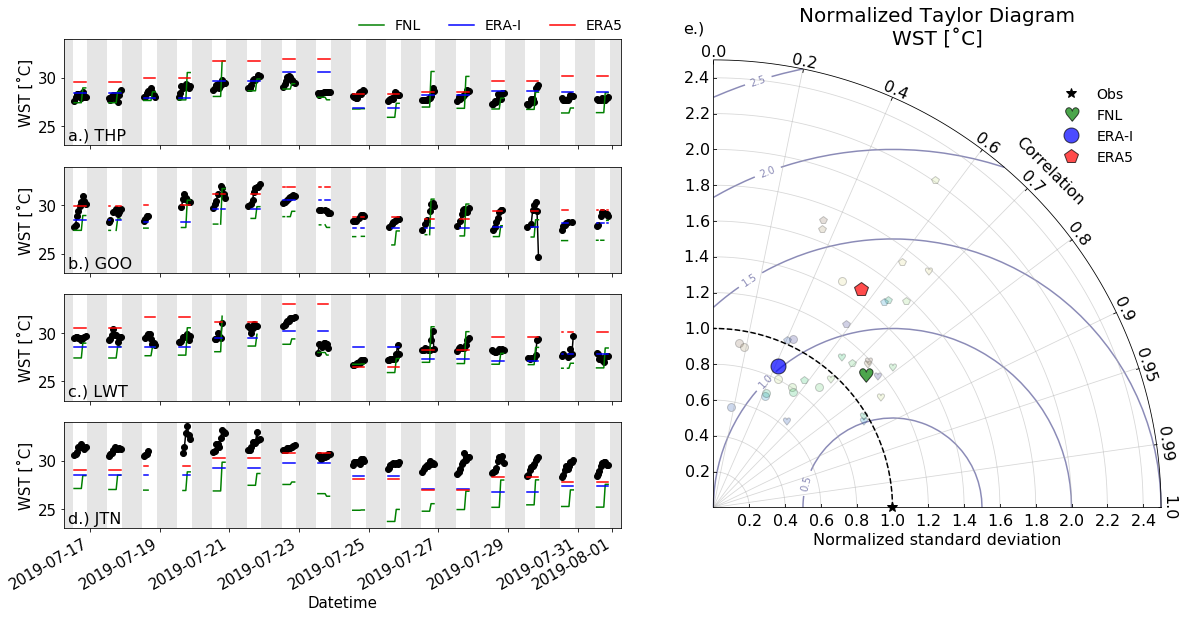

In [39]:
var           = 'sst'

#var           = 'wspd'
#var_str       = 'Wind Speed\n[m s$^{-1}$]'
stns_for_plot = ['THP','GOO','LWT','JTN']
if var == 'wspd':
    ymin,ymax = 0,15
    ylabel = 'Wind Speed [m s$^{-1}$]'
if var == 'wdir':
    ymin,ymax = 0,0.5
if var == 'sst':
    ymin,ymax = 22,34
    ylabel = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]

fig = plt.figure(figsize=(18,9))
gs1 = gridspec.GridSpec(len(stns_for_plot), 1)
gs1.update(left=0.05, right=0.48, wspace=0.05)
#ax1 = plt.subplot(gs1[0])
#ax2 = plt.subplot(gs1[1])
#ax3 = plt.subplot(gs1[2])
#ax4 = plt.subplot(gs1[3])

for ss,stn in enumerate(stns_for_plot):
    ax1 = plt.subplot(gs1[ss])
    

    obs = TD_obs_full[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax1,c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax1,label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
    ax1.set_title('')
    ax1.set_ylabel(var_str_dict[var],size=15)
    if ss == 3:
        ax1.set_xlabel('Datetime',size=15)
        ax1.tick_params(labelsize=15)
    else:
        ax1.set_xlabel('')
        ax1.tick_params(labelbottom=False,labelsize=15)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax1.fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
    ymin,ymax = 23,34
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax1.text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    if ss == 0: ax1.legend(frameon=False,ncol=4,loc=(0.52,1.01),fontsize=14,handlelength=1.75)

#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = False
if var == 'pres':
    TD_max_r = 1.3
elif var == 'temp':
    TD_max_r = 1.5
elif var == 'wspd':
    TD_max_r = 1.5
elif var == 'sst':
    TD_max_r = 2.5
    extend = False
else:
    TD_max_r = 1.5
    
dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.2),
                    labelsize=16)
td_stats = {}


for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        if case_plt_dict['fill']:
            marker_c = stn_colors[stn]
            marker_e = 'k'
        else:
            marker_c = stn_colors[stn]
            marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        dia.add_sample(np.std(sim.data), r2,
                       marker=case_plt_dict['marker'], ms=8, ls='',
                       mfc=marker_c, mec=marker_e, # Colors
                       label=label_str,
                       zorder=cc,alpha=0.2)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(0.75,0.75),ncol=1)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.01)
plt.text(-0.05,2.65,'e.)',size=16,ha='right')
figname = '{}ICBC_TD_SST'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

In [41]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

cases_of_interest = [
                     'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     'ERA5_YSU_CHRN_ER5_NOSK_3DOM', 
                     'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
                     'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                     'ERA5_YSU_CHRN_ER5_OVER_3DOM',
                     'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                     'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                     'ERAI_YSU_CHRN_OST_OVER_3DOM',
                    ]

doms_of_interest  = [3]*len(cases_of_interest)

/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/AuxSST_5panel


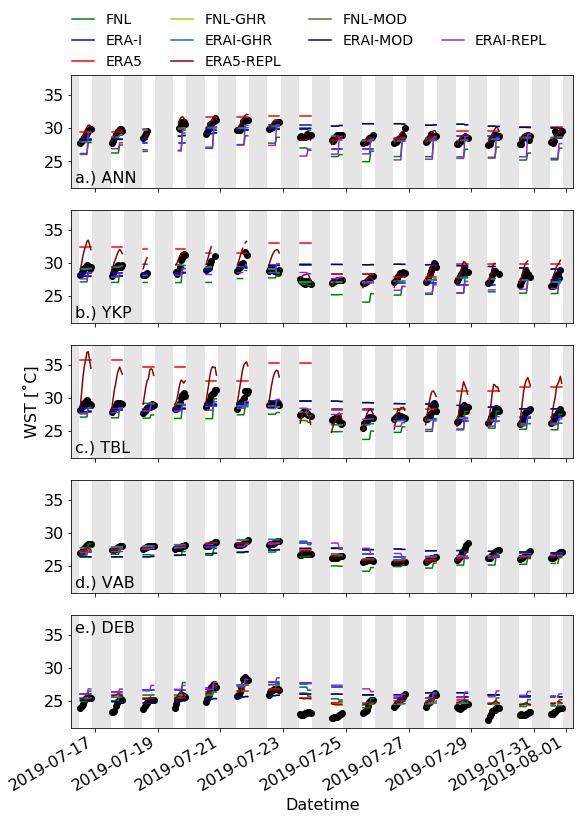

In [42]:
stns_for_plot = ['ANN','YKP','TBL','VAB','DEB']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(len(stns_for_plot),sharex=True,figsize=(9,12))

lines = []
for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss],c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            lines += sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
        if ss == 0:
            if case == 'ERAI_YSU_CHRN_MOD_NOSK_3DOM':
                ax[0].plot(sim.datetime.data[0],0.0, color='w', alpha=0, label=' ')
                ax[0].plot(sim.datetime.data[0],0.0, color='w', alpha=0, label=' ')
    ax[ss].set_ylabel(var_str_dict[var],size=16)
    if ss == len(TD_stns) - 1:
        ax[ss].set_xlabel('Datetime',size=16)
    else:
        ax[ss].set_xlabel('')
    if ss == 0:
        ax[ss].set_title(var,size=18)
    else:
        ax[ss].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 21,38
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    ax[ss].set_yticks(np.arange(5,46,5))
    ax[ss].set_ylim(ymin,ymax)
    ax[ss].tick_params(labelsize=16)
    if ss == 2:
        ax[ss].set_ylabel(var_str,size=16)
    else:
        ax[ss].set_ylabel('')

    ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax[ss].text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)


ax[0].legend(frameon=False,ncol=4,loc=(-0.01,1.01),fontsize=14,handlelength=1.6)


ax[0].set_title('')
ax[-1].set_xlabel('Datetime',size=16)
figname = '{}AuxSST_5panel'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


In [43]:
stn_pair_dict = {'ERAI_YSU_CHRN_OST_SKNT_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_GHR_NOSK_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_GHR_SKNT_3DOM':'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                 'ERAI_YSU_CHRN_MOD_NOSK_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_MOD_SKNT_3DOM':'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                 'ERAI_YSU_CHRN_OST_OVER_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_OST_OVSK_3DOM':'ERAI_YSU_CHRN_OST_OVER_3DOM',
                 
                 'GFSR_YSU_CHRN_GFS_SKNT_3DOM':'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                 'GFSR_YSU_CHRN_GHR_NOSK_3DOM':'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                 'GFSR_YSU_CHRN_GHR_SKNT_3DOM':'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
                 'GFSR_YSU_CHRN_MOD_NOSK_3DOM':'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                 'GFSR_YSU_CHRN_MOD_SKNT_3DOM':'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                 
                 'ERA5_YSU_CHRN_ER5_OVER_3DOM':'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                 'ERA5_YSU_CHRN_ER5_SKNT_3DOM':'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                 'ERA5_YSU_CHRN_ER5_OVSK_3DOM':'ERA5_YSU_CHRN_ER5_OVER_3DOM',
                }

In [44]:
cases_of_interest = [
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                     'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                     'ERAI_YSU_CHRN_OST_OVER_3DOM',
                     'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
                     'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                     'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                     'ERA5_YSU_CHRN_ER5_OVER_3DOM',
                    ]

ERAI_YSU_CHRN_GHR_NOSK_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_MOD_NOSK_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_OST_OVER_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
GFSR_YSU_CHRN_GHR_NOSK_3DOM GFSR_YSU_CHRN_GFS_NOSK_3DOM
GFSR_YSU_CHRN_MOD_NOSK_3DOM GFSR_YSU_CHRN_GFS_NOSK_3DOM
ERA5_YSU_CHRN_ER5_OVER_3DOM ERA5_YSU_CHRN_ER5_NOSK_3DOM
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/AuxSST_TD


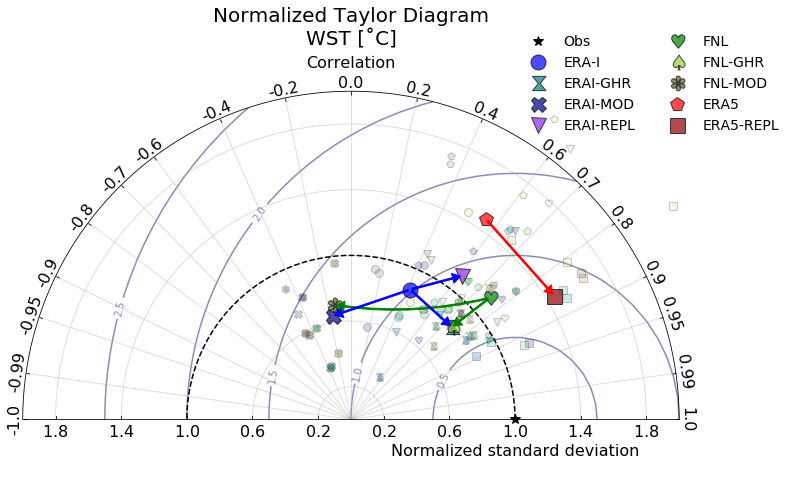

In [45]:
var = 'sst'
fig = plt.figure(figsize=(12,8))
#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = False
if var == 'pres':
    TD_max_r = 1.3
elif var == 'temp':
    TD_max_r = 1.5
elif var == 'wspd':
    TD_max_r = 1.5
elif var == 'sst':
    TD_max_r = 2.0
    extend = True
else:
    TD_max_r = 1.5
    
dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    #rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.4),
                    labelsize=16)
td_stats = {}

sample_dict = {}
for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        if case_plt_dict['fill']:
            marker_c = stn_colors[stn]
            marker_e = 'k'
        else:
            marker_c = stn_colors[stn]
            marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        dia.add_sample(np.std(sim.data), r2,
                       marker=case_plt_dict['marker'], ms=8, ls='',
                       mfc=marker_c, mec=marker_e, # Colors
                       label=label_str,
                       zorder=cc,alpha=0.2)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        sample_dict[case] = dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                                        norm=False, # don't normalize this point
                                        marker=case_plt_dict['marker'], ms=15, ls='',
                                        mfc=case_plt_dict['color'], mec='k', # Colors
                                        label=case_plt_dict['name'],
                                        zorder=cc+3,alpha=0.7)

for cc,case in enumerate(cases_of_interest):
    if case in stn_pair_dict.keys():
        print(case,stn_pair_dict[case])
        arrow_origin = sample_dict[stn_pair_dict[case]].get_xydata()
        arrow_end    = sample_dict[case].get_xydata()
        arrow_xs,arrow_ys = np.squeeze(arrow_origin)
        arrow_xe,arrow_ye = np.squeeze(arrow_end)
        arrow_dx,arrow_dy = np.squeeze(arrow_end) - np.squeeze(arrow_origin)
        arrow_len_weight = 0.7
        if case == 'GFSR_YSU_CHRN_MOD_NOSK_3DOM':
            connection_style = 'arc3,rad=-.1'
        else:
            connection_style = None
        arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                        color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                        arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
        dia.ax.add_patch(arrow)
        #dia.ax.arrow(arrow_x,arrow_y,arrow_dx*arrow_len_weight,arrow_dy*arrow_len_weight,
        #             width=0.025,zorder=6,color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
        #             head_width=0.08,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(0.75,0.85),ncol=2)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(var_str_dict[var].split('\n')[0])),size=20,y=1.11)
figname = '{}AuxSST_TD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

In [53]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

In [54]:
cases_of_interest = [
                     'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
                     'ERAI_YSU_CHRN_OST_SKNT_3DOM',
                     'ERA5_YSU_CHRN_ER5_SKNT_3DOM', 
                     'GFSR_YSU_CHRN_GHR_SKNT_3DOM',
                     'ERAI_YSU_CHRN_GHR_SKNT_3DOM',
                     'ERA5_YSU_CHRN_ER5_OVSK_3DOM',
                     'GFSR_YSU_CHRN_MOD_SKNT_3DOM',
                     'ERAI_YSU_CHRN_MOD_SKNT_3DOM',
                     'ERAI_YSU_CHRN_OST_OVSK_3DOM',
                    ]

/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/SST_SKIN_5panel


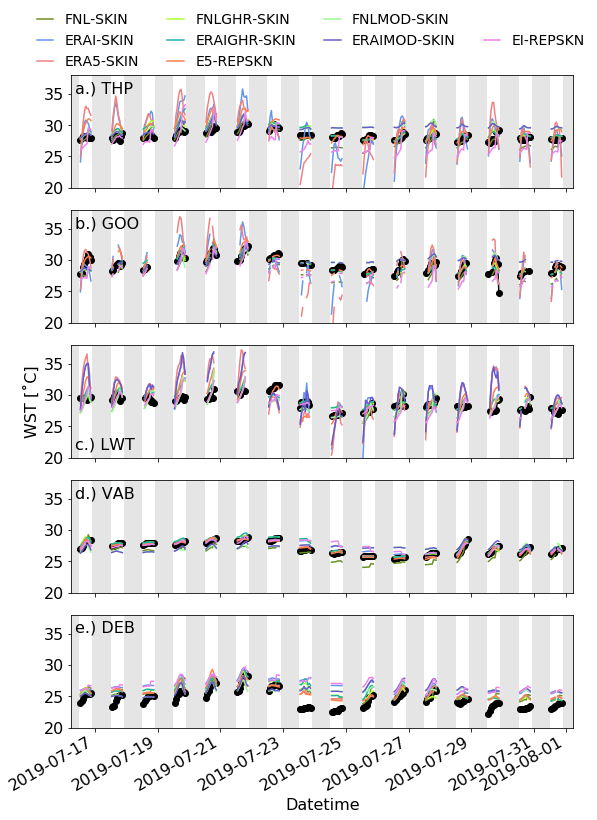

In [55]:
stns_for_plot = ['ANN','FLG','JTN','VAB','DEB']
stns_for_plot = ['THP','GOO','LWT','VAB','DEB']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(len(stns_for_plot),sharex=True,figsize=(9,12))
for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss],c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])

        if ss == 0:
            if case == 'ERAI_YSU_CHRN_MOD_SKNT_3DOM':
                ax[0].plot(sim.datetime.data[0],0.0, color='w', alpha=0, label=' ')
                ax[0].plot(sim.datetime.data[0],0.0, color='w', alpha=0, label=' ')            
            
    ax[ss].set_ylabel(sim_var,size=16)
    if ss == len(TD_stns) - 1:
        ax[ss].set_xlabel('Datetime',size=16)
    else:
        ax[ss].set_xlabel('')
    if ss == 0:
        ax[ss].set_title(var,size=18)
    else:
        ax[ss].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 20,38
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    ax[ss].set_yticks(np.arange(5,46,5))
    ax[ss].set_ylim(ymin,ymax)
    ax[ss].tick_params(labelsize=16)
    if ss == 2:
        ax[ss].set_ylabel(var_str,size=16)
    else:
        ax[ss].set_ylabel('')

    ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    if stn == 'LWT':
        txty = ymin + 0.05*(ymax-ymin)
        va = 'bottom'
        txtx = 3
    else:
        txty = ymax - 0.05*(ymax-ymin)
        va = 'top'
        txtx = 3

    ax[ss].text(obs.datetime.data[txtx],txty,'{}.) {}'.format(ascii_lowercase[ss],stn),va=va,ha='left',size=16)

    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
ax[0].legend(frameon=False,ncol=4,loc=(-0.08,1.01),fontsize=14,handlelength=1.2)
ax[0].set_title('')
ax[-1].set_xlabel('Datetime',size=16)
figname = '{}SST_SKIN_5panel'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


# 2-D Histograms

In [26]:
def create_2dHistogram(varA,varB,n_binsA,n_binsB):
    '''
    Returns the x, y, and z arrays to plot a 2-D histogram
    given two variables, A (x-axis) and B (y-axis).
    To call:
    x,y,z = create_2dHistogram(variableA,variableB,number_of_bins)
    To plot, call:
    plt.pcolormesh(x,y, z,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()))
    '''
    varA_flat = varA.flatten()
    varB_flat = varB.flatten()
    varA_vs_varB, ab_xedges, ab_yedges = np.histogram2d(varA_flat, varB_flat, bins=[n_binsA,n_binsB])
    x_2d, y_2d = np.meshgrid(ab_xedges,ab_yedges)
    return(x_2d,y_2d,varA_vs_varB.T)

In [27]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

In [37]:
save_figs = False

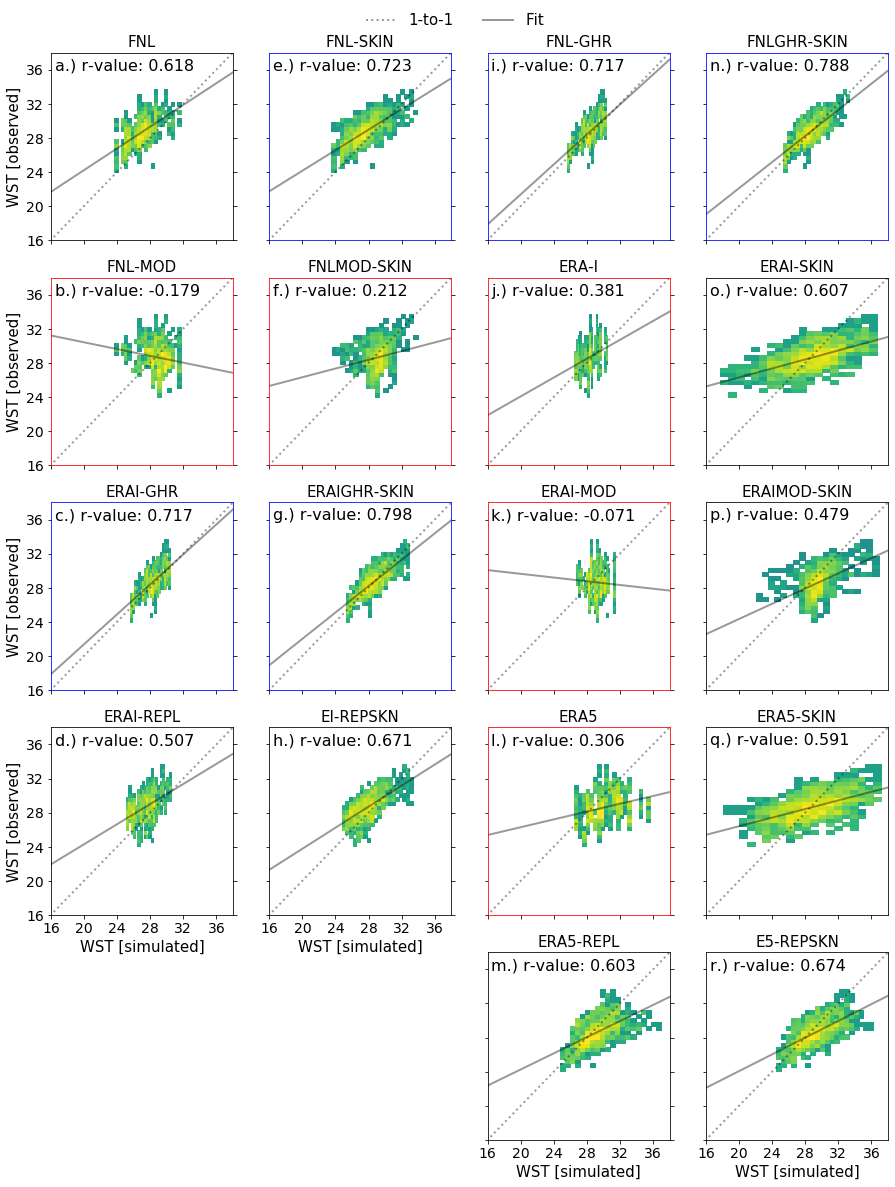

In [43]:
#for var in vars_to_compare:
for var in ['sst']:
    obs_var = var
    sim_var = vars_to_compare[var]
    if var == 'sst'    : var_str = 'WST'
    if var == 'wspd'   : var_str = 'Wind Speed'
    if var == 'temp'   : var_str = '2 m Temperature'
    if var == 'pres'   : var_str = 'Surface Pressure'
    if var == 't_diff' : var_str = '∆T'
    fig,ax = plt.subplots(nrows=5,ncols=4,figsize=(15,20),sharey=True,sharex=True)
    row = 0
    col = 0
    case_performance_dict = {}
    for cc,case in enumerate(cases_of_interest):
        if case == 'ERA5_YSU_CHRN_ER5_OVER_3DOM': col+=2
        for ss,stn in enumerate(TD_stns):

            obs = TD_obs_full[stn][obs_var]
            obs = obs.dropna(how='any',dim='datetime')

            case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
            sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')

            varA = sim.data
            varB = obs.data
            
            if ss == 0:
                varA_f = varA
                varB_f = varB
            else:
                varA_f = np.concatenate((varA_f,varA))
                varB_f = np.concatenate((varB_f,varB))
        if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
            slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)
            x2d,y2d,hist2d = create_2dHistogram(varA_f,varB_f,20,20)

            ax[row,col].pcolormesh(x2d,y2d, hist2d,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()),rasterized=True)
            #plt.colorbar()
            if col == 0: ax[row,col].set_ylabel('{} [observed]'.format(var_str),size=15)
            if row == 4: ax[row,col].set_xlabel('{} [simulated]'.format(var_str),size=15)
            if row == 3:
                if col < 2: 
                    ax[row,col].set_xlabel('{} [simulated]'.format(var_str),size=15)
                    ax[row,col].tick_params(labelbottom=True)
            ref_x = np.arange(-1000,1001)
            if cc == 0:
                line_lbl1 = '1-to-1'
                line_lbl2 = 'Fit'
            else:
                line_lbl1 = None
                line_lbl2 = None
            ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.4,ls=':',label=line_lbl1)
            ax[row,col].plot(ref_x,slope*ref_x + intercept,c='k',lw=2.0,alpha=0.4,label=line_lbl2)
            if cc == 0: ax[0,0].legend(frameon=False,loc=(1.7,1.1),fontsize=15,ncol=2)
            if var == 'sst':
                xmin,xmax = (np.nanmin(y2d)-10,np.nanmax(y2d)+3)
                ymin,ymax = (np.nanmin(y2d)-0.5,np.nanmax(y2d+0.5))
                ymin,ymax = 23,35
                ymin,ymax = 16,38
                xmin,xmax = 16,38
            else:
                xmin,xmax = (np.nanmin(y2d),np.nanmax(y2d))
                ymin,ymax = (np.nanmin(y2d),np.nanmax(y2d))
            if var == 'wdir':
                ymin,ymax = 0,360
            if col < 3:
                letter_ind = row + col*4
            else:
                letter_ind = row + col*4 + 1
            ax[row,col].text(xmin+0.02*(xmax-xmin),ymin+0.97*(ymax-ymin),'{1}.) r-value: {0:4.3f}'.format(
                                                                        r_value,ascii_lowercase[letter_ind]), size=16,va='top')
            ax[row,col].set_title(case_plt_dict['name'],size=15)
            ax[row,col].tick_params(labelsize=14)
            if var == 'sst':
                xtick_min,xtick_max,xtick_int = 12,42,4
                ytick_min,ytick_max,ytick_int = 24,38,2
                ytick_min,ytick_max,ytick_int = 12,42,4
            elif var == 'temp':
                xtick_min,xtick_max,xtick_int = 20,35,5
                ytick_min,ytick_max,ytick_int = 20,35,5
            elif var == 'wspd':
                xtick_min,xtick_max,xtick_int = 0,10,2
                ytick_min,ytick_max,ytick_int = 0,10,2
            elif var == 'pres':
                xtick_min,xtick_max,xtick_int = 1000,1020,5
                ytick_min,ytick_max,ytick_int = 1000,1020,5
            elif var == 't_diff':
                xtick_min,xtick_max,xtick_int = -12,13,4
                ytick_min,ytick_max,ytick_int = -12,13,4


            ax[row,col].set_xticks(np.arange(xtick_min,xtick_max+1,xtick_int))
            ax[row,col].set_yticks(np.arange(ytick_min,ytick_max+1,ytick_int))
            ax[row,col].set_xlim(xmin,xmax)
            ax[row,col].set_ylim(ymin,ymax)
            
            if col < 3:
                ax[row,col].tick_params(right=True)
            col += 1
            if col == 4:
                col = 0
                row += 1
            #if case == ''
            #plt.setp(ax[row,col].spines.values(), color='r')
            
            case_performance_dict[case] = r_value
    #plt.setp([ax[0,0].get_xticklines(), ax[0,0].get_yticklines()], color='k')
    sorted_performance = dict(sorted(case_performance_dict.items(), key=lambda x: x[1]))
    row = 0
    col = 0
    for cc,case in enumerate(cases_of_interest):
        if case == 'ERA5_YSU_CHRN_ER5_OVER_3DOM': col+=2
        if case in list(sorted_performance.keys())[:5]:
            plt.setp(ax[row,col].spines.values(), color='r')
        elif case in list(sorted_performance.keys())[-5:]:
            plt.setp(ax[row,col].spines.values(), color='b')
        col += 1
        if col == 4:
            col = 0
            row += 1
    ax[4,0].set_visible(False)
    ax[4,1].set_visible(False)
    figname = '{}SST_SKIN_2Dhist_equal'.format(save_dir)
    if save_figs:
        plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
        plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
        print(figname)
    plt.show()
    print()
    print()
    
    
                
        

In [60]:
cases_of_interest_chunks = [
    ['GFSR_YSU_CHRN_GFS_NOSK_3DOM',
     'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
     'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
     'GFSR_YSU_CHRN_GHR_SKNT_3DOM',
     'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
     'GFSR_YSU_CHRN_MOD_SKNT_3DOM'],
    
    ['ERAI_YSU_CHRN_OST_NOSK_4DOM',
     'ERAI_YSU_CHRN_OST_SKNT_3DOM',
     'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
     'ERAI_YSU_CHRN_GHR_SKNT_3DOM',
     'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
     'ERAI_YSU_CHRN_MOD_SKNT_3DOM',
     'ERAI_YSU_CHRN_OST_OVER_3DOM',
     'ERAI_YSU_CHRN_OST_OVSK_3DOM'],
    
    ['ERA5_YSU_CHRN_ER5_NOSK_3DOM',
     'ERA5_YSU_CHRN_ER5_OVER_3DOM',
     'ERA5_YSU_CHRN_ER5_SKNT_3DOM',
     'ERA5_YSU_CHRN_ER5_OVSK_3DOM']
]

GFSR_YSU_CHRN_GFS_SKNT_3DOM GFSR_YSU_CHRN_GFS_NOSK_3DOM
GFSR_YSU_CHRN_GHR_SKNT_3DOM GFSR_YSU_CHRN_GHR_NOSK_3DOM
GFSR_YSU_CHRN_MOD_SKNT_3DOM GFSR_YSU_CHRN_MOD_NOSK_3DOM
ERAI_YSU_CHRN_OST_SKNT_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_GHR_SKNT_3DOM ERAI_YSU_CHRN_GHR_NOSK_3DOM
ERAI_YSU_CHRN_MOD_SKNT_3DOM ERAI_YSU_CHRN_MOD_NOSK_3DOM
ERAI_YSU_CHRN_OST_OVSK_3DOM ERAI_YSU_CHRN_OST_OVER_3DOM
ERA5_YSU_CHRN_ER5_SKNT_3DOM ERA5_YSU_CHRN_ER5_NOSK_3DOM
ERA5_YSU_CHRN_ER5_OVSK_3DOM ERA5_YSU_CHRN_ER5_OVER_3DOM
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/SST_SKIN_SST_TD


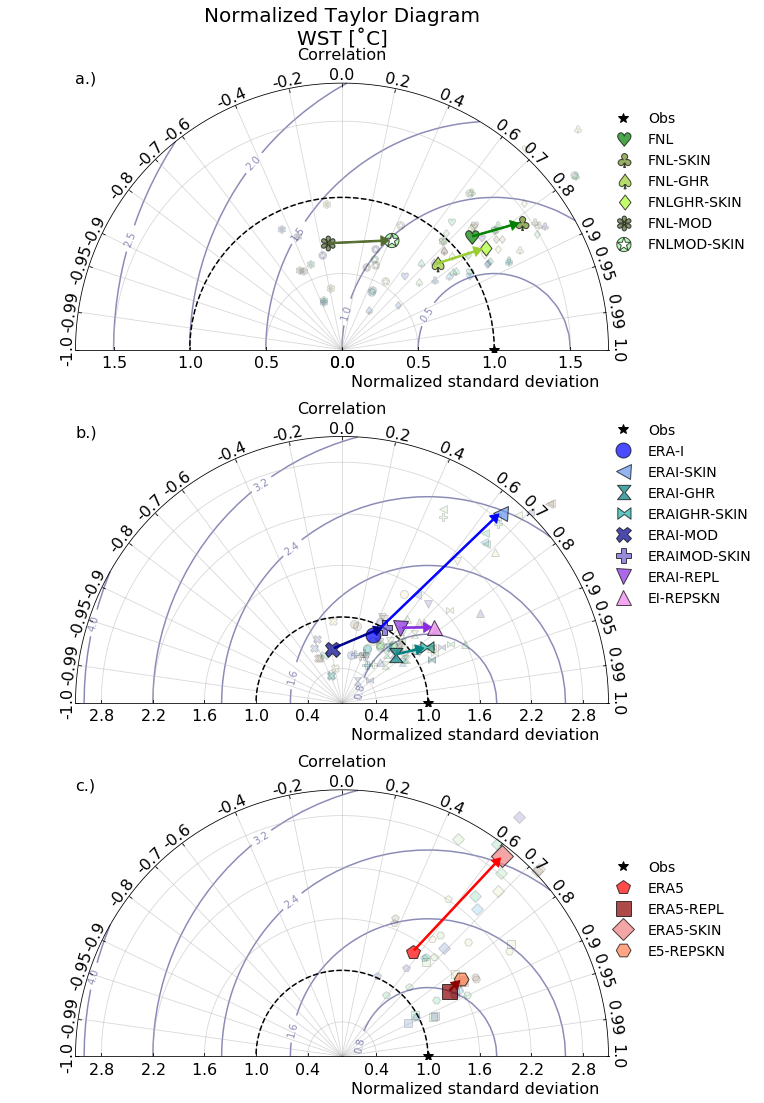

In [61]:
var = 'sst'
fig = plt.figure(figsize=(12,18))
plt.subplots_adjust(hspace=0.3)
#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = True

    
rect = 311
for coi,cases_of_interest in enumerate(cases_of_interest_chunks):
    if coi == 0:
        TD_max_r = 1.75
        stdevticks = np.arange(0.0,5.6,0.5)
    else:
        TD_max_r = 3.1
        stdevticks = np.arange(0.4,5.6,0.6)

    dia = TaylorDiagram(1.0, fig=fig, 
                        extend=extend,
                        rect=rect,
                        label='Obs',
                        normalize=True,
                        srange=[0.0,TD_max_r],
                        stdevticks=stdevticks,
                        labelsize=16)
    td_stats = {}
    sample_dict = {}

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

        for ss,stn in enumerate(TD_stns):

            obs = TD_obs_full[stn][obs_var]
            obs = obs.dropna(how='any',dim='datetime')
            sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')

            ref_std = np.std(obs.data)
            sim_std = np.std(sim.data)

            r2,_ = pearsonr(sim, obs)

            if ss == 0: 
                obs_full = obs - np.nanmean(obs)
                sim_full = sim - np.nanmean(sim)
                #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
                label_str = None
            else:
                obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
                sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
                label_str = None
            #print(case,stn,np.std(sim.data)/ref_std)
            if case_plt_dict['fill']:
                marker_c = stn_colors[stn]
                marker_e = 'k'
            else:
                marker_c = stn_colors[stn]
                marker_e = stn_colors[stn]

            td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
            td_stats[case].loc[stn,'R2'] = r2

            dia.set_ref(ref_std)

            dia.add_sample(np.std(sim.data), r2,
                           marker=case_plt_dict['marker'], ms=8, ls='',
                           mfc=marker_c, mec=marker_e, # Colors
                           label=label_str,
                           zorder=cc,alpha=0.15)

                #if cc == 0:
                #    txt_x = 0.38 + 0.17*stn_count
                #    txt_y = 0.12
                    #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                    #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                    #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

        multimodal_mean = False

        if multimodal_mean:
            ref_std_full = np.std(obs_full)

            dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
                   marker=case_plt_dict['marker'], ms=15, ls='',
                   mfc=case_plt_dict['color'], mec='k', # Colors
                   label=case_plt_dict['name'],
                   zorder=cc+3,alpha=0.7)
        else:        
            td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
            td_mean = td_stats[case].mean(axis=0)
            sample_dict[case] = dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                                            norm=False, # don't normalize this point
                                            marker=case_plt_dict['marker'], ms=15, ls='',
                                            mfc=case_plt_dict['color'], mec='k', # Colors
                                            label=case_plt_dict['name'],
                                            zorder=cc+3,alpha=0.7)

    connecting_cases = []
    for case in cases_of_interest:
        if ('SKNT' in case) or ('OVSK' in case):
            connecting_cases.append(case)

    for cc,case in enumerate(connecting_cases):
        if case in stn_pair_dict.keys():
            print(case,stn_pair_dict[case])
            arrow_origin = sample_dict[stn_pair_dict[case]].get_xydata()
            arrow_end    = sample_dict[case].get_xydata()
            arrow_xs,arrow_ys = np.squeeze(arrow_origin)
            arrow_xe,arrow_ye = np.squeeze(arrow_end)
            arrow_dx,arrow_dy = np.squeeze(arrow_end) - np.squeeze(arrow_origin)
            arrow_len_weight = 0.7
            if case == 'GFSR_YSU_CHRN_MOD_NOSK_3DOM':
                connection_style = 'arc3,rad=.5'
            else:
                connection_style = None
            arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                            color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                            arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
            dia.ax.add_patch(arrow)
    contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    dia.add_grid(alpha=0.5)
    plt.legend(frameon=False,fontsize=14,loc=(0.98,0.35),ncol=1)
    if coi == 0: plt.title('Normalized Taylor Diagram\n{}'.format(''.join(var_str_dict[var].split('\n')[0])),size=20,y=1.11)
    plt.text(-TD_max_r,TD_max_r,'{}.)'.format(ascii_lowercase[coi]),size=16)
    rect += 1
figname = '{}SST_SKIN_SST_TD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()